In [2]:
import os
import numpy as np
import time
import pickle
import imp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt


from cruw import CRUW
from rodnet.datasets.CRDataset import CRDataset
from rodnet.datasets.collate_functions import cr_collate
from rodnet.utils.solve_dir import create_dir_for_new_model
from rodnet.utils.load_configs import load_configs_from_file, parse_cfgs, update_config_dict
from rodnet.utils.visualization import visualize_train_img, visualize_test_img_wo_gt, visualize_confmap, visualize_test_img
from rodnet.core.post_processing import ConfmapStack, post_process, post_process_single_frame, write_dets_results, write_dets_results_single_frame, lnms, ops

/var/folders/lj/_chmmmhd2m5328svknqdk8b80000gn/T/ipykernel_32671/670376179.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<Figure size 800x800 with 0 Axes>

In [3]:
config_dict = load_configs_from_file('/Users/kushalgadhiya/Desktop/Winter2024/ENDG 511/Project/RODNet-master/configs/config_rodnet_cdc_win16.py')
dataset = CRUW(data_root=config_dict['dataset_cfg']['base_root'], sensor_config_name='sensor_config_rod2021')
radar_configs = dataset.sensor_cfg.radar_cfg
range_grid = dataset.range_grid         
angle_grid = dataset.angle_grid         
model_cfg = config_dict['model_cfg']

In [4]:
crdata_train = CRDataset(data_dir='/Volumes/T7MAC/data_v3', dataset=dataset, config_dict=config_dict, split='train',
                                 noise_channel= False)
print(len(crdata_train))

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

3058


In [5]:
n_class = dataset.object_cfg.n_class          
n_epoch = config_dict['train_cfg']['n_epoch']   
batch_size = config_dict['train_cfg']['batch_size'] 
lr = config_dict['train_cfg']['lr']
train_configs = config_dict['train_cfg']
test_configs = config_dict['test_cfg']
win_size = train_configs['win_size']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
testdata, valdata = torch.utils.data.random_split(crdata_train,[2358,700])

In [7]:
tdataloader = DataLoader(testdata, batch_size, shuffle=True, num_workers=0, collate_fn=cr_collate)
vdataloader = DataLoader(valdata, batch_size =1, shuffle=True, num_workers=0, collate_fn=cr_collate)

In [181]:
# data_details = pickle.load(open(data_file_path, 'rb'))

In [221]:
train_model_path = '/Volumes/T7MAC/trainedrepo'         #entre your desired location to store trained model
if not os.path.exists(train_model_path):
    os.makedirs(train_model_path)
test_res_dir_base = os.path.join(os.path.join('/Volumes/T7MAC/resultrepo', 'base'))
if not os.path.exists(test_res_dir_base):
    os.makedirs(test_res_dir_base)
test_res_dir_multi = os.path.join(os.path.join('/Volumes/T7MAC/resultrepo', 'multi'))
if not os.path.exists(test_res_dir_multi):
    os.makedirs(test_res_dir_multi)

In [9]:
import getModel
imp.reload(getModel)
from getModel import ROD_V0, ROD_V1
import trainModel
imp.reload(trainModel)
from trainModel import modelHandler,baseHandler

In [10]:
rod_v0 = ROD_V0(in_channels=2, n_class=n_class).to(device)
optimizer_v0 = optim.Adam(rod_v0.parameters(), lr=lr)
criterion_v0 = nn.BCELoss()
scheduler_v0 = StepLR(optimizer_v0, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

M_v0 = baseHandler(rod_v0,criterion_v0,optimizer_v0,device,scheduler_v0,n_epoch)

Number of encoder parameters: 28601088
Number of decoder long parameters: 5919174


In [11]:
rod_v1 = ROD_V1(in_channels=2, n_class=n_class).to(device)
optimizer_v1 = optim.Adam(rod_v1.parameters(), lr=lr)
criterion_v1 = nn.BCELoss()
scheduler_v1 = StepLR(optimizer_v1, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

M_v1 = modelHandler(rod_v1,criterion_v1,optimizer_v1,device,scheduler_v1,n_epoch)

Number of encoder parameters: 6481152
Number of decoder short parameters: 1200453
Number of decoder long parameters: 28039110


***Train base Model***

epoch 1 --> trainLoss: 0.001
saving current epoch model ...
epoch 2 --> trainLoss: 0.001
saving current epoch model ...
epoch 3 --> trainLoss: 0.001
saving current epoch model ...


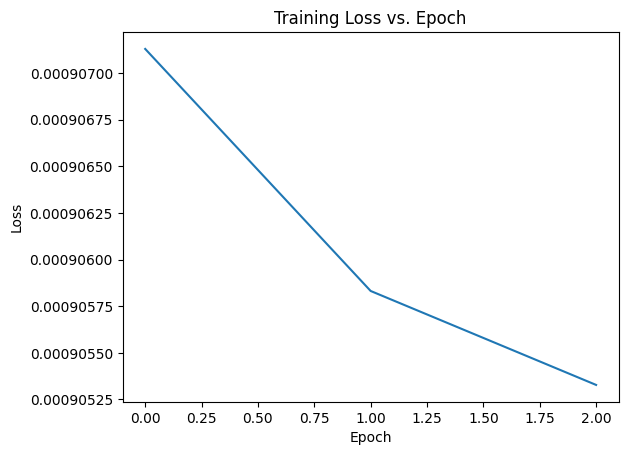

In [11]:
rodNet_v0, history_v0 = M_v0.train(tdataloader,train_model_path)
total_loss = history_v0['train']['loss']
epochs = np.array([i for i in range(3)])
plt.plot(epochs, total_loss)
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

***Train multibranch model***

epoch 1 --> shortbranchloss: 0.001, longbranchloss: 0.001, totalloss: 0.001
saving current epoch model ...
epoch 2 --> shortbranchloss: 0.001, longbranchloss: 0.001, totalloss: 0.001
saving current epoch model ...
epoch 3 --> shortbranchloss: 0.001, longbranchloss: 0.001, totalloss: 0.001
saving current epoch model ...


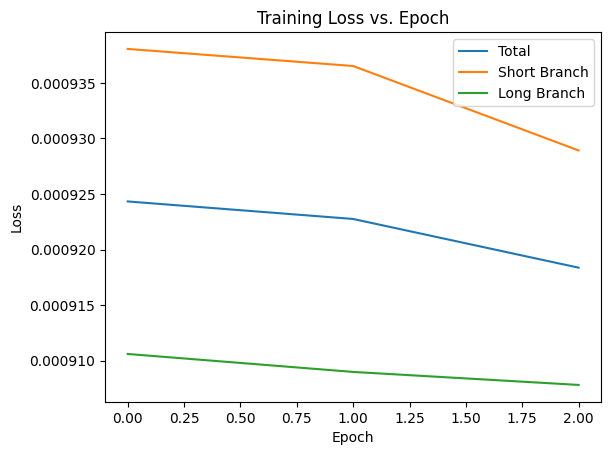

In [12]:
rodNet_v1, history_v1 = M_v1.train(tdataloader,train_model_path)
total_loss = history_v1['T']['train']['loss']
short_branch_loss = history_v1['1']['train']['loss']
long_branch_loss = history_v1['2']['train']['loss']
epochs = np.array([i for i in range(3)])
plt.plot(epochs, total_loss, label='Total')
plt.plot(epochs,short_branch_loss, label='Short Branch')
plt.plot(epochs,long_branch_loss, label='Long Branch')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
from cruw.eval import evaluate_rodnet_seq
from cruw.eval.rod.rod_eval_utils import accumulate, summarize
from cruw.eval.rod.load_txt import read_gt_txt, read_sub_txt, read_rodnet_res
from cruw.eval.rod.rod_eval_utils import compute_ols_dts_gts, evaluate_img, accumulate, summarize

In [18]:
rod_v0 = ROD_V0(in_channels=2, n_class=n_class).to(device)
#rod_v0.load_state_dict(torch.load(os.path.join(train_model_path,'base_epoch_0{}_final.pkl'.format(n_epoch))))
rod_v0.load_state_dict(torch.load('/Users/kushalgadhiya/Desktop/pklfiles/trainedrepo/base_epoch_05_final.pkl', map_location=torch.device('cpu')))
rod_v0.eval()
validation_loss_class_0 = []
validation_loss_class_1 = []
validation_loss_class_2 = []
ols_ans = []
with torch.no_grad():
    for iter, data_dict in enumerate(vdataloader):
        data = data_dict['radar_data'].to(device)
        confmap_gt = data_dict['anno']['confmaps'].to(device)
        seq_name = data_dict['seq_names'][0]
        start_frame = data_dict['start_frame'].item()
        end_frame = data_dict['end_frame'].item()
        confmap_pred = rod_v0(data.float())
        loss_class_0 = criterion_v0(confmap_pred[:,0,:,:,:], confmap_gt[:,0,:,:,:].float()).item()
        loss_class_1 = criterion_v0(confmap_pred[:,1,:,:,:], confmap_gt[:,1,:,:,:].float()).item()
        loss_class_2 = criterion_v0(confmap_pred[:,2,:,:,:], confmap_gt[:,2,:,:,:].float()).item()
        validation_loss_class_0.append(loss_class_0)
        validation_loss_class_1.append(loss_class_1)
        validation_loss_class_2.append(loss_class_2)
        pred = confmap_pred[0,:,0,:,:]
        print(seq_name)
        print(start_frame)
        result = post_process_single_frame(pred.cpu().detach().numpy(), dataset, config_dict)
        
        seq_res_dir = os.path.join(test_res_dir_base, seq_name)
        if not os.path.exists(seq_res_dir):
            os.makedirs(seq_res_dir)
        f = open(os.path.join(seq_res_dir, 'rod_res.txt'), 'a')
        f.close()
        save_path = os.path.join(test_res_dir_base, seq_name, 'rod_res.txt')

        write_dets_results_single_frame(result, start_frame, save_path, dataset)
        
        gt_path = os.path.join('/Volumes/T7MAC/ROD2024/annotations/train', seq_name.upper() + '.txt')
        data_path = os.path.join(dataset.data_root, 'sequences', 'train', gt_path.split('/')[-1][:-4])
        n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
        gt_dets = read_gt_txt(gt_path, n_frame, dataset)
        sub_dets = read_rodnet_res(save_path, n_frame, dataset)
        olss_all = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets, start_frame, catId, dataset) \
                    for catId in range(3)}
        ols_ans.append(olss_all)
   

Number of encoder parameters: 28601088
Number of decoder long parameters: 5919174
2019_04_30_PM2S004
236
2019_04_30_PM2S004
200
2019_04_30_MLMS000
492
2019_09_29_ONRD006
712
2019_05_29_PBMS007
412
2019_04_09_BMS1000
240
2019_04_09_BMS1000
444
2019_09_29_ONRD002
200
2019_04_30_PBMS002
812
2019_04_30_PM2S004
192
2019_04_30_PM2S004
180
2019_09_29_ONRD002
232
2019_04_09_BMS1000
64
2019_05_09_CM1S004
760
2019_04_30_PCMS001
792
2019_09_29_ONRD006
572
2019_04_09_BMS1000
24
2019_04_30_MLMS000
716
2019_04_30_PM2S004
272
2019_04_09_PMS1000
352
2019_04_30_PCMS001
632
2019_04_30_PBMS002
140
2019_04_09_PMS1000
244
2019_09_29_ONRD006
616
2019_05_29_BCMS000
876
2019_05_09_CM1S004
136
2019_05_29_PBMS007
624
2019_09_29_ONRD002
844
2019_05_09_CM1S004
304
2019_04_30_MLMS002
264
2019_09_29_ONRD002
1112
2019_09_29_ONRD006
684
2019_04_30_PM2S004
564
2019_04_30_PCMS001
480
2019_05_09_CM1S004
880
2019_04_30_PM2S004
528
2019_05_29_BCMS000
80
2019_09_29_ONRD002
1668
2019_04_30_PBMS002
88
2019_09_29_ONRD002
204


In [85]:
print(ols_ans[1])

{(120, 0): [], (120, 1): [], (120, 2): array([[9.62350909e-01, 1.94902894e-02, 7.56866024e-01, 3.91041386e-04,
        6.43059538e-07],
       [8.18173865e-01, 1.32224094e-02, 9.40431254e-01, 6.19731305e-04,
        1.03776771e-06],
       [8.18173865e-01, 1.32224094e-02, 9.40431254e-01, 6.19731305e-04,
        1.03776771e-06],
       [9.02459941e-01, 1.61858832e-02, 8.63634600e-01, 5.01584653e-04,
        8.26291112e-07],
       [9.93871652e-01, 3.30410635e-02, 5.15748506e-01, 3.42119395e-04,
        6.05490517e-07],
       [1.33884329e-03, 9.22186982e-01, 6.61682293e-06, 4.90559598e-04,
        4.68201296e-05],
       [4.96048250e-01, 8.91470811e-03, 9.34387405e-01, 1.93501362e-03,
        3.92888833e-06],
       [3.81206090e-03, 7.31687655e-01, 2.12270961e-05, 1.41817138e-04,
        7.56224446e-06],
       [1.33884329e-03, 9.22186982e-01, 6.61682293e-06, 4.90559598e-04,
        4.68201296e-05],
       [3.81206090e-03, 7.31687655e-01, 2.12270961e-05, 1.41817138e-04,
        7.562244

In [19]:
print(len(validation_loss_class_0))

700


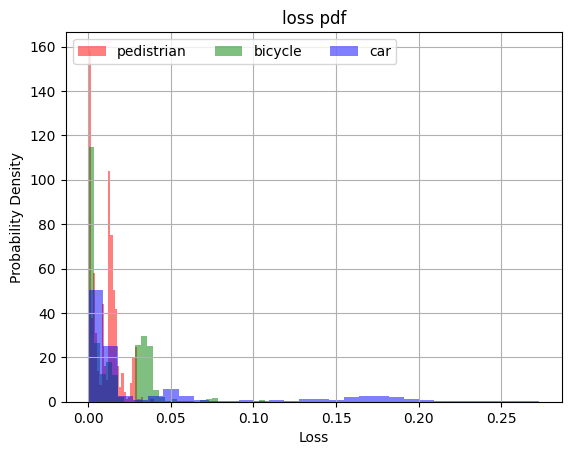

In [20]:
plt.hist(np.round(np.array(validation_loss_class_0),3), bins=30, color='red', alpha=0.5, label='pedistrian',density=True)
plt.hist(np.round(np.array(validation_loss_class_1),3), bins=30, color='green', alpha=0.5, label='bicycle',density=True)
plt.hist(np.round(np.array(validation_loss_class_2),3), bins=30, color='blue', alpha=0.5, label='car',density=True)
plt.title('loss pdf')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)
plt.show()

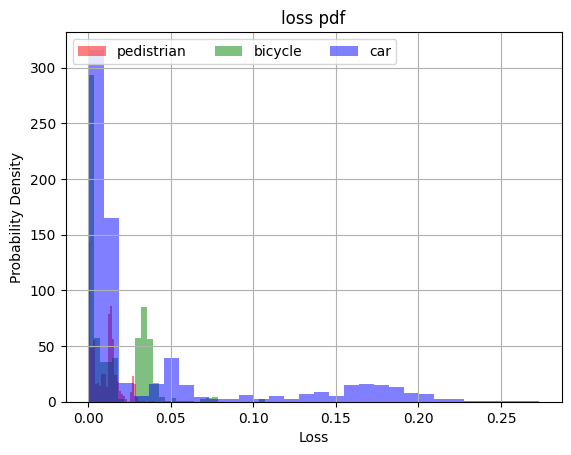

In [24]:
plt.hist(np.round(np.array(validation_loss_class_0),6), bins=30, color='red', alpha=0.5, label='pedistrian')
plt.hist(np.round(np.array(validation_loss_class_1),6), bins=30, color='green', alpha=0.5, label='bicycle')
plt.hist(np.round(np.array(validation_loss_class_2),6), bins=30, color='blue', alpha=0.5, label='car')
plt.title('loss pdf')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)
plt.show()

In [53]:
rod_v1 = ROD_V1(in_channels=2, n_class=n_class).to(device)
rod_v1.load_state_dict(torch.load(os.path.join(train_model_path,'multi_epoch_0{}_final.pkl'.format(n_epoch)), map_location=torch.device('cpu')))
rod_v1.eval()
val_loss_class_0_short = []
val_loss_class_1_short = []
val_loss_class_2_short = []
val_loss_class_0_long = []
val_loss_class_1_long = []
val_loss_class_2_long = []
early_exit_count = 0
ols_ans_1 = []
ols_ans_2 = []
early_exit_count = 0
with torch.no_grad():
    for iter, data_dict in enumerate(vdataloader):
        data = data_dict['radar_data'].to(device)
        confmap_gt = data_dict['anno']['confmaps'].to(device)
        seq_name = data_dict['seq_names'][0]
        if seq_name == '2019_09_29_ONRD006':
            continue
        start_frame = data_dict['start_frame'].item()
        end_frame = data_dict['end_frame'].item()
        confmap_preds_1,confmap_preds_2 = rod_v1(data.float())
        loss_1_class0, loss_2_class0 = criterion_v1(confmap_preds_1[:,0,:,:,:], confmap_gt[:,0,:,:,:].float()), criterion_v1(confmap_preds_2[:,0,:,:,:], confmap_gt[:,0,:,:,:].float())
        loss_1_class1, loss_2_class1 = criterion_v1(confmap_preds_1[:,1,:,:,:], confmap_gt[:,1,:,:,:].float()), criterion_v1(confmap_preds_2[:,1,:,:,:], confmap_gt[:,1,:,:,:].float())
        loss_1_class2, loss_2_class2 = criterion_v1(confmap_preds_1[:,2,:,:,:], confmap_gt[:,2,:,:,:].float()), criterion_v1(confmap_preds_2[:,2,:,:,:], confmap_gt[:,2,:,:,:].float())
        val_loss_class_0_short.append(loss_1_class0)
        val_loss_class_1_short.append(loss_1_class1)
        val_loss_class_2_short.append(loss_1_class2)
        val_loss_class_0_long.append(loss_2_class0)
        val_loss_class_1_long.append(loss_2_class1)
        val_loss_class_2_long.append(loss_2_class2)

        pred1 = confmap_preds_1[0,:,0,:,:]
        pred2 = confmap_preds_2[0,:,0,:,:]

        print(seq_name)
        print(start_frame)
        result1 = post_process_single_frame(pred1, dataset, config_dict)
        result2 = post_process_single_frame(pred2, dataset, config_dict)
        
        seq_res_dir = os.path.join(test_res_dir_multi, seq_name)
        if not os.path.exists(seq_res_dir):
            os.makedirs(seq_res_dir)
        f1 = open(os.path.join(seq_res_dir, 'rod_res_1.txt'), 'a')
        f2 = open(os.path.join(seq_res_dir, 'rod_res_2.txt'), 'a')
        f1.close()
        f2.close()
        save_path_1 = os.path.join(test_res_dir_multi, seq_name, 'rod_res_1.txt')
        save_path_2 = os.path.join(test_res_dir_multi, seq_name, 'rod_res_2.txt')

        write_dets_results_single_frame(result1, start_frame, save_path_1, dataset)
        write_dets_results_single_frame(result2, start_frame, save_path_2, dataset)
        
        gt_path = os.path.join('/Volumes/T7MAC/ROD2024/annotations/train', seq_name.upper() + '.txt')
        data_path = os.path.join(dataset.data_root, 'sequences', 'train', gt_path.split('/')[-1][:-4])
        n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
        gt_dets = read_gt_txt(gt_path, n_frame, dataset)
        if gt_dets[start_frame,0] == None and gt_dets[start_frame,1] == None and gt_dets[start_frame,2] == None:
            continue
        sub_dets_1 = read_rodnet_res(save_path_1, n_frame, dataset)
        sub_dets_2 = read_rodnet_res(save_path_2, n_frame, dataset)
        olss_all_1 = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets_1, start_frame, catId, dataset) \
                    for catId in range(3)}
        olss_all_2 = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets_2, start_frame, catId, dataset) \
                    for catId in range(3)}
        ols_ans_1.append(olss_all_1)
        ols_ans_1.append(olss_all_2)
        
        if(len(gt_dets[start_frame,0]) == len(sub_dets_1[start_frame,0]) and len(gt_dets[start_frame,1]) == len(sub_dets_1[start_frame,1]) and len(gt_dets[start_frame,2]) == len(sub_dets_1[start_frame,2])):
            early_exit_count += 1
        
    print("Number of samples will exit early {}".format(early_exit_count))
        # print('ground_truth')
        # print(gt_dets[start_frame,0])
        # print(gt_dets[start_frame,1])
        # print(gt_dets[start_frame,2])
        # print('predicted 1')
        # print(sub_dets_1[start_frame,0])
        # print(sub_dets_1[start_frame,1])
        # print(sub_dets_1[start_frame,2])
        # print('predicted 2')
        # print(sub_dets_2[start_frame,0])
        # print(sub_dets_2[start_frame,1])
        # print(sub_dets_2[start_frame,2])
        # print(olss_all)

Number of encoder parameters: 6481152
Number of decoder short parameters: 1200453
Number of decoder long parameters: 28039110
2019_04_30_PM2S004
180
2019_05_29_PBMS007
708
2019_04_09_PMS1000
692
2019_09_29_ONRD002
1572
2019_04_30_MLMS002
4
2019_04_30_PCMS001
532
2019_04_09_PMS1000
124
2019_04_09_BMS1000
240
2019_04_30_PBMS002
676
2019_04_30_MLMS002
540
2019_05_09_CM1S004
244
2019_04_30_MLMS000
788
2019_04_30_MLMS000
344
2019_04_30_MLMS000
276
2019_05_09_CM1S004
124
2019_04_30_MLMS000
464
2019_05_09_CM1S004
156
2019_09_29_ONRD002
192
2019_09_29_ONRD002
1132
2019_05_29_BCMS000
372
2019_09_29_ONRD002
1268
2019_04_30_MLMS002
264
2019_05_09_CM1S004
56
2019_04_30_PM2S004
788
2019_04_09_BMS1000
708
2019_04_30_MLMS002
196
2019_04_30_PM2S004
156
2019_04_30_PBMS002
404
2019_04_09_PMS1000
24
2019_04_30_PBMS002
96
2019_04_09_PMS1000
696
2019_04_30_MLMS002
560
2019_04_30_PBMS002
372
2019_04_09_PMS1000
140
2019_04_30_MLMS002
508
2019_09_29_ONRD002
692
2019_09_29_ONRD002
1612
2019_05_29_PBMS007
568
2

In [51]:
print(gt_dets[1660,2])

[{'frame_id': 1660, 'range': 15.1282, 'angle': -0.5137, 'class_name': 'car', 'class_id': 2, 'id': 338, 'score': 1.0}]


In [59]:
print(len(val_loss_class_0_long))

598


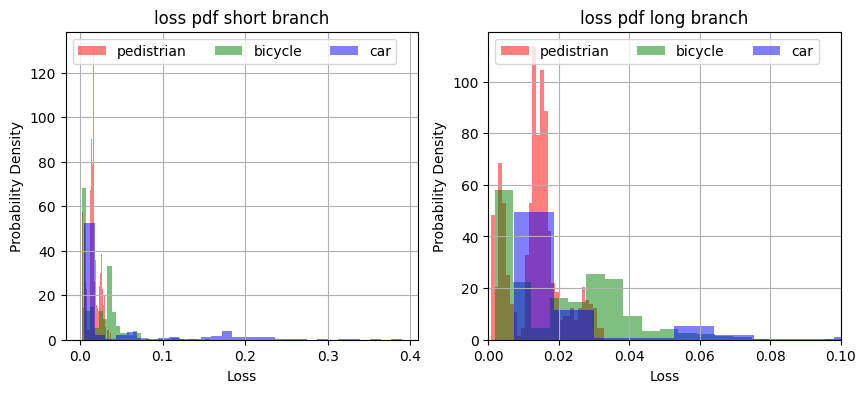

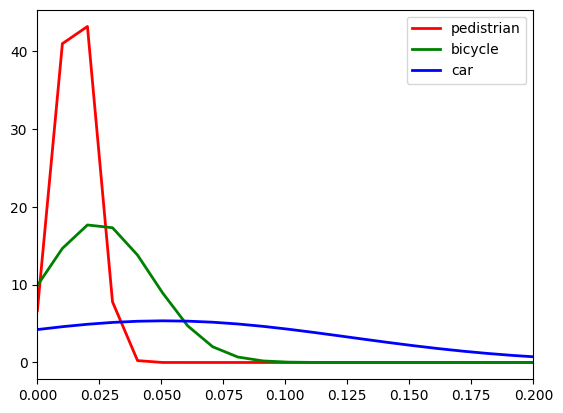

In [77]:
from scipy.stats import norm
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hist(np.round(np.array(val_loss_class_0_short),3), bins=30, color='red', alpha=0.5, label='pedistrian',density=True)
plt.hist(np.round(np.array(val_loss_class_1_short),3), bins=30, color='green', alpha=0.5, label='bicycle',density=True)
plt.hist(np.round(np.array(val_loss_class_2_short),3), bins=30, color='blue', alpha=0.5, label='car',density=True)
plt.title('loss pdf short branch')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(np.round(np.array(val_loss_class_0_long),8), bins=30, color='red', alpha=0.5, label='pedistrian',density=True)
plt.hist(np.round(np.array(val_loss_class_1_long),8), bins=30, color='green', alpha=0.5, label='bicycle',density=True)
plt.hist(np.round(np.array(val_loss_class_2_long),8), bins=30, color='blue', alpha=0.5, label='car',density=True)
plt.title('loss pdf long branch')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
plt.legend(loc='upper left', ncol=3)
plt.grid(True)
plt.xlim([0,0.1])
plt.show()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, loc=np.mean(val_loss_class_0_short), scale=np.std(val_loss_class_0_short))
p1 = norm.pdf(x, loc=np.mean(val_loss_class_1_short), scale=np.std(val_loss_class_1_short))
p2 = norm.pdf(x, loc=np.mean(val_loss_class_2_short), scale=np.std(val_loss_class_2_short))
plt.plot(x, p, linewidth=2, label = 'pedistrian', color = 'red')
plt.plot(x, p1, linewidth=2, label = 'bicycle', color = 'green')
plt.plot(x, p2, linewidth=2, label = 'car', color = 'blue')
plt.xlim([0,0.2])
plt.legend()

*********************

In [216]:
crdata_valid = CRDataset(data_dir='/Volumes/T7MAC/data_valid', dataset=dataset, config_dict=config_dict, split='train',
                                 noise_channel= False)

100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


In [217]:
testdataloader = DataLoader(crdata_valid, 1, shuffle=True, num_workers=0, collate_fn=cr_collate)

In [218]:
print(len(testdataloader))

444


In [224]:
rod_v0 = ROD_V0(in_channels=2, n_class=n_class).to(device)
rod_v0.load_state_dict(torch.load('/Users/kushalgadhiya/Desktop/pklfiles/trainedrepo/base_epoch_05_final.pkl', map_location=torch.device('cpu')))
rod_v0.eval()
init_genConfmap = ConfmapStack((3,128,128))
with torch.no_grad():
    for iter, data_dict in enumerate(testdataloader):
        data = data_dict['radar_data'].to(device)
        confmap_gt = data_dict['anno']['confmaps'].to(device)
        seq_name = data_dict['seq_names'][0]
        start_frame_id = data_dict['start_frame'].item()
        end_frame_id = data_dict['end_frame'].item()
        confmap_pred = rod_v0(data.float())
        tic = time.time()
        confmap_pred = confmap_pred.cpu().detach().numpy()
        infer_time = time.time() - tic
        seq_res_dir = os.path.join(test_res_dir_base, seq_name)
        if not os.path.exists(seq_res_dir):
            os.makedirs(seq_res_dir)
        f = open(os.path.join(seq_res_dir, 'rod_res.txt'), 'a')
        f.close()
        save_path = os.path.join(test_res_dir_base, seq_name, 'rod_res.txt')

        iter_ = init_genConfmap
        for i in range(confmap_pred.shape[2]):
            if iter_.next is None and i != confmap_pred.shape[2] - 1:
                iter_.next = ConfmapStack((3,128,128))
            iter_.append(confmap_pred[0, :, i, :, :])
            iter_ = iter_.next

        process_tic = time.time()
        res_final = post_process_single_frame(init_genConfmap.confmap, dataset, config_dict)
        cur_frame_id = start_frame_id + i
        write_dets_results_single_frame(res_final, cur_frame_id, save_path, dataset)
        confmap_pred_0 = init_genConfmap.confmap
        res_final_0 = res_final
        init_genConfmap = init_genConfmap.next
        
        if iter == len(testdataloader) - 1:
            offset = train_configs['train_stride']
            cur_frame_id = start_frame_id + offset
            while init_genConfmap is not None:
                res_final = post_process_single_frame(init_genConfmap.confmap, dataset, config_dict)
                write_dets_results_single_frame(res_final, cur_frame_id, save_path, dataset)
                confmap_pred_0 = init_genConfmap.confmap
                res_final_0 = res_final
                init_genConfmap = init_genConfmap.next
                offset += 1
                cur_frame_id += 1
    
        if init_genConfmap is None:
                init_genConfmap = ConfmapStack((3,128,128))

        proc_time = time.time() - process_tic
        print("Testing %s: frame %4d to %4d | Inference time: %.4f | Process time: %.4f" %
                (seq_name, start_frame_id, end_frame_id, infer_time, proc_time))

        load_tic = time.time()

Number of encoder parameters: 28601088
Number of decoder long parameters: 5919174
Testing 2019_04_30_MLMS000: frame  428 to  443 | Inference time: 0.0000 | Process time: 0.7948
Testing 2019_04_30_MLMS000: frame   36 to   51 | Inference time: 0.0000 | Process time: 0.7842
Testing 2019_04_30_MLMS000: frame  280 to  295 | Inference time: 0.0000 | Process time: 0.8557
Testing 2019_04_30_MLMS000: frame  660 to  675 | Inference time: 0.0000 | Process time: 0.7745
Testing 2019_04_30_MLMS000: frame  408 to  423 | Inference time: 0.0000 | Process time: 0.7797
Testing 2019_05_29_PBMS007: frame  168 to  183 | Inference time: 0.0000 | Process time: 0.7736
Testing 2019_05_29_PBMS007: frame  360 to  375 | Inference time: 0.0000 | Process time: 0.7654
Testing 2019_05_29_PBMS007: frame  112 to  127 | Inference time: 0.0000 | Process time: 0.7827
Testing 2019_05_29_PBMS007: frame  792 to  807 | Inference time: 0.0000 | Process time: 0.7647
Testing 2019_04_30_MLMS000: frame  832 to  847 | Inference time

In [225]:
olsThrs = np.around(np.linspace(0.5, 0.9, int(np.round((0.9 - 0.5) / 0.05) + 1), endpoint=True), decimals=2)
recThrs = np.around(np.linspace(0.0, 1.0, int(np.round((1.0 - 0.0) / 0.01) + 1), endpoint=True), decimals=2)
seq_names = sorted(os.listdir('/Volumes/T7MAC/resultrepo/base'))
seq_names = [name for name in seq_names if '.' not in name]

evalImgs_all = []
n_frames_all = 0

for seq_name in seq_names:
    gt_path = os.path.join('/Volumes/T7MAC/ROD2024/annotations/train', seq_name.upper() + '.txt')
    res_path = os.path.join('/Volumes/T7MAC/resultrepo/base', seq_name, 'rod_res.txt')

    data_path = os.path.join(dataset.data_root, 'sequences', 'train', gt_path.split('/')[-1][:-4])
    n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
    evalImgs = evaluate_rodnet_seq(res_path, gt_path, n_frame, dataset)
    eval = accumulate(evalImgs, n_frame, olsThrs, recThrs, dataset, log=False)
    stats = summarize(eval, olsThrs, recThrs, dataset, gl=False)
    print("%s | AP_total: %.4f | AR_total: %.4f" % (seq_name.upper(), stats[0] * 100, stats[1] * 100))

    n_frames_all += n_frame
    evalImgs_all.extend(evalImgs)

eval = accumulate(evalImgs_all, n_frames_all, olsThrs, recThrs, dataset, log=False)
stats = summarize(eval, olsThrs, recThrs, dataset, gl=False)
print("%s | AP_total: %.4f | AR_total: %.4f" % ('Overall'.ljust(18), stats[0] * 100, stats[1] * 100))

2019_04_30_MLMS000 | AP_total: 0.0977 | AR_total: 0.0542
2019_05_29_PBMS007 | AP_total: 0.0000 | AR_total: 0.0000
Overall            | AP_total: 0.1045 | AR_total: 0.0289


*****************************

***************Part2********************

In [154]:
olsThrs = np.around(np.linspace(0.5, 0.9, int(np.round((0.9 - 0.5) / 0.05) + 1), endpoint=True), decimals=2)
recThrs = np.around(np.linspace(0.0, 1.0, int(np.round((1.0 - 0.0) / 0.01) + 1), endpoint=True), decimals=2)

In [155]:
print(olsThrs)
print(recThrs)

[0.5]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


In [131]:
import math
from cruw.mapping.object_types import get_class_id
from cruw.eval.metrics import get_ols_btw_objects

def read_rodnet_res(filename, start_frame, dataset):
    n_class = dataset.object_cfg.n_class
    classes = dataset.object_cfg.classes
    rng_grid = dataset.range_grid
    agl_grid = dataset.angle_grid

    with open(filename, 'r') as df:
        data = df.readlines()
    if len(data) == 0:
        return None

    dts = {(i, j): [] for i in range(1) for j in range(n_class)}

    for id, line in enumerate(data):
        if line is not None:
            line = line.rstrip().split()
            frameid, class_str, ridx, aidx, conf = line
            frameid = int(frameid)
            if frameid != start_frame:
                continue
            classid = get_class_id(class_str, classes)
            ridx = int(ridx)
            aidx = int(aidx)
            conf = float(conf)
            if conf > 1:
                conf = 1
            rng = rng_grid[ridx]
            agl = agl_grid[aidx]
            if rng > 25 or rng < 1:
                continue
            if agl > math.radians(60) or agl < math.radians(-60):
                continue
            obj_dict = dict(
                id=id + 1,
                frame_id=frameid,
                range=rng,
                angle=agl,
                range_id=ridx,
                angle_id=aidx,
                class_id=classid,
                score=conf
            )
            dts[0, classid].append(obj_dict)

    return dts
def read_gt_txt(txt_path, start_frame, dataset):
    n_class = dataset.object_cfg.n_class
    classes = dataset.object_cfg.classes
    with open(txt_path, 'r') as f:
        data = f.readlines()
    dets = [None] * 1
    for line in data:
        frame_id, r, a, class_name = line.rstrip().split()
        frame_id = int(frame_id)
        if(frame_id != start_frame):
            continue
        r = float(r)
        a = float(a)
        class_id = classes.index(class_name)
        obj_dict = dict(
            frame_id=frame_id,
            range=r,
            angle=a,
            class_name=class_name,
            class_id=class_id
        )
        if dets[0] is None:
            dets[0] = [obj_dict]
        else:
            dets[0].append(obj_dict)

    gts = {(i, j): [] for i in range(1) for j in range(n_class)}
    id = 1
    for frameid, obj_info in enumerate(dets):
        # for each frame
        if obj_info is None:
            continue
        for obj_dict in obj_info:
            rng = obj_dict['range']
            agl = obj_dict['angle']
            class_id = obj_dict['class_id']
            if rng > 25 or rng < 1:
                continue
            if agl > math.radians(60) or agl < math.radians(-60):
                continue
            obj_dict_gt = obj_dict.copy()
            obj_dict_gt['id'] = id
            obj_dict_gt['score'] = 1.0
            gts[0, class_id].append(obj_dict_gt)
            id += 1

    return gts
def compute_ols_dts_gts(gts_dict, dts_dict, imgId, catId, dataset):
    """Compute OLS between detections and gts for a category in a frame."""
    gts = gts_dict[imgId, catId]
    dts = dts_dict[imgId, catId]
    inds = np.argsort([-d['score'] for d in dts], kind='mergesort')
    dts = [dts[i] for i in inds]
    if len(gts) == 0 or len(dts) == 0:
        return []
    olss = np.zeros((len(dts), len(gts)))
    # compute oks between each detection and ground truth object
    for j, gt in enumerate(gts):
        for i, dt in enumerate(dts):
            olss[i, j] = get_ols_btw_objects(gt, dt, dataset)
    return olss
def evaluate_img(gts_dict, dts_dict, frame_ID, catId, olss_dict, olsThrs, recThrs, dataset, log=False):
    classes = dataset.object_cfg.classes

    gts = gts_dict[0, catId]
    dts = dts_dict[0, catId]
    if len(gts) == 0 and len(dts) == 0:
        return None

    if log:
        olss_flatten = np.ravel(olss_dict[frame_ID, catId])
        print("Frame %d: %10s %s" % (frame_ID, classes[catId], list(olss_flatten)))

    dtind = np.argsort([-d['score'] for d in dts], kind='mergesort')
    dts = [dts[i] for i in dtind]
    olss = olss_dict[frame_ID, catId]

    T = len(olsThrs)
    G = len(gts)
    D = len(dts)
    gtm = np.zeros((T, G))
    dtm = np.zeros((T, D))

    if not len(olss) == 0:
        for tind, t in enumerate(olsThrs):
            for dind, d in enumerate(dts):
                # information about best match so far (m=-1 -> unmatched)
                iou = min([t, 1 - 1e-10])
                m = -1
                for gind, g in enumerate(gts):
                    # if this gt already matched, continue
                    if gtm[tind, gind] > 0:
                        continue
                    if olss[dind, gind] < iou:
                        continue
                    # if match successful and best so far, store appropriately
                    iou = olss[dind, gind]
                    m = gind
                # if match made store id of match for both dt and gt
                if m == -1:
                    # no gt matched
                    continue
                dtm[tind, dind] = gts[m]['id']
                gtm[tind, m] = d['id']
    # store results for given image and category
    return {
        'image_id': frame_ID,
        'category_id': catId,
        'dtIds': [d['id'] for d in dts],
        'gtIds': [g['id'] for g in gts],
        'dtMatches': dtm,
        'gtMatches': gtm,
        'dtScores': [d['score'] for d in dts],
    }

In [94]:
rod_v0 = ROD_V0(in_channels=2, n_class=n_class).to(device)
#rod_v0.load_state_dict(torch.load(os.path.join(train_model_path,'base_epoch_0{}_final.pkl'.format(n_epoch))))
rod_v0.load_state_dict(torch.load('/Users/kushalgadhiya/Desktop/pklfiles/trainedrepo/base_epoch_05_final.pkl', map_location=torch.device('cpu')))
rod_v0.eval()
validation_loss_class_0 = []
validation_loss_class_1 = []
validation_loss_class_2 = []
ols_ans = []
with torch.no_grad():
    for iter, data_dict in enumerate(vdataloader):
        data = data_dict['radar_data'].to(device)
        confmap_gt = data_dict['anno']['confmaps'].to(device)
        seq_name = data_dict['seq_names'][0]
        start_frame = data_dict['start_frame'].item()
        end_frame = data_dict['end_frame'].item()
        confmap_pred = rod_v0(data.float())
        loss_class_0 = criterion_v0(confmap_pred[:,0,:,:,:], confmap_gt[:,0,:,:,:].float()).item()
        loss_class_1 = criterion_v0(confmap_pred[:,1,:,:,:], confmap_gt[:,1,:,:,:].float()).item()
        loss_class_2 = criterion_v0(confmap_pred[:,2,:,:,:], confmap_gt[:,2,:,:,:].float()).item()
        validation_loss_class_0.append(loss_class_0)
        validation_loss_class_1.append(loss_class_1)
        validation_loss_class_2.append(loss_class_2)
        pred = confmap_pred[0,:,0,:,:]
        print(seq_name)
        result = post_process_single_frame(pred.cpu().detach().numpy(), dataset, config_dict)
        
        seq_res_dir = os.path.join(test_res_dir_base, seq_name)
        if not os.path.exists(seq_res_dir):
            os.makedirs(seq_res_dir)
        f = open(os.path.join(seq_res_dir, 'rod_res.txt'), 'a')
        f.close()
        save_path = os.path.join(test_res_dir_base, seq_name, 'rod_res.txt')

        write_dets_results_single_frame(result, start_frame, save_path, dataset)
        
        gt_path = os.path.join('/Volumes/T7MAC/ROD2024/annotations/train', seq_name.upper() + '.txt')
        data_path = os.path.join(dataset.data_root, 'sequences', 'train', gt_path.split('/')[-1][:-4])
        n_frame = len(os.listdir(os.path.join(data_path, dataset.sensor_cfg.camera_cfg['image_folder'])))
        gt_dets = read_gt_txt(gt_path, start_frame, dataset)
        if len(gt_dets[0,0]) == 0 and len(gt_dets[0,1]) == 0  and len(gt_dets[0,2]) == 0:
            continue
        sub_dets = read_rodnet_res(save_path, start_frame, dataset)
        olss_all = {(start_frame, catId): compute_ols_dts_gts(gt_dets, sub_dets, 0, catId, dataset) \
                    for catId in range(3)}
        # evalImgs = [evaluate_img(gt_dets, sub_dets, 0, catId, olss_all, olsThrs, recThrs, dataset)
        #         for catId in range(3)]
        print("gts")
        print(gt_dets[0,0])
        print(gt_dets[0,1])
        print(gt_dets[0,2])
        print("dts")
        print(sub_dets[0,0])
        print(sub_dets[0,1])
        print(sub_dets[0,2])
        print("ols")
        print(olss_all[start_frame,0])
        print(olss_all[start_frame,1])
        print(olss_all[start_frame,2])
        
        break
   

Number of encoder parameters: 28601088
Number of decoder long parameters: 5919174
2019_04_30_PBMS002
gts
[{'frame_id': 764, 'range': 11.1521, 'angle': -0.192, 'class_name': 'pedestrian', 'class_id': 0, 'id': 1, 'score': 1.0}]
[{'frame_id': 764, 'range': 9.5908, 'angle': 0.3142, 'class_name': 'cyclist', 'class_id': 1, 'id': 2, 'score': 1.0}]
[]
dts
[{'id': 24, 'frame_id': 764, 'range': 10.865797969872943, 'angle': -0.1981444157461321, 'range_id': 48, 'angle_id': 51, 'class_id': 0, 'score': 0.3222}, {'id': 94, 'frame_id': 764, 'range': 10.865797969872943, 'angle': -0.1981444157461321, 'range_id': 48, 'angle_id': 51, 'class_id': 0, 'score': 0.3103}]
[{'id': 23, 'frame_id': 764, 'range': 11.078852832027314, 'angle': -0.24658582604881113, 'range_id': 49, 'angle_id': 48, 'class_id': 1, 'score': 0.3259}, {'id': 93, 'frame_id': 764, 'range': 11.078852832027314, 'angle': -0.24658582604881113, 'range_id': 49, 'angle_id': 48, 'class_id': 1, 'score': 0.3191}]
[{'id': 21, 'frame_id': 764, 'range': 

In [156]:
evalImgs = [evaluate_img(gt_dets, sub_dets, start_frame, catId, olss_all, olsThrs, recThrs, dataset)
            for catId in range(3)]

In [165]:
T = len(olsThrs)
R = len(recThrs)
K = n_class
precision = -np.ones((T, R, K))  # -1 for the precision of absent categories
recall = -np.ones((T, K))
scores = -np.ones((T, R, K))
n_objects = np.zeros((K,))
for classid in range(n_class):
    E = [evalImgs[classid]]
    dtScores = np.concatenate([e['dtScores'] for e in E])
    inds = np.argsort(-dtScores, kind='mergesort')
    dtScoresSorted = dtScores[inds]

    dtm = np.concatenate([e['dtMatches'] for e in E], axis=1)[:, inds]
    gtm = np.concatenate([e['gtMatches'] for e in E], axis=1)
    nd = dtm.shape[1]  # number of detections
    ng = gtm.shape[1]  # number of ground truth
    n_objects[classid] = ng
    tps = np.array(dtm, dtype=bool)
    fps = np.logical_not(dtm)
    tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float64)
    fp_sum = np.cumsum(fps, axis=1).astype(dtype=np.float64)
    for t, (tp, fp) in enumerate(zip(tp_sum, fp_sum)):
        tp = np.array(tp)
        fp = np.array(fp)
        rc = tp / (ng + np.spacing(1))
        pr = tp / (fp + tp + np.spacing(1))
        print(rc)
        break

[1. 1.]
[0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
